# DFT-calculated structures (COOH, CHO) and analysis

The data below from the pickle files contain the following information

| Column Name | Data Type            | Description      | 
|-------------|----------------------|------------------|
| NP      | `str`      | Id of nanoparticle model (main text) | 
| adsorbate        | `str`      | Adsorbate |
| atoms    | `ase.atoms.Atoms`                | ASE atomic object of the optimized structure |
| energy   | `numpy.float64`    | Total energy (eV)  |
| max_force        | `numpy.float64`        | Max force after DFT optimization (ev A-2) |
| BE        | `numpy.float64`        | Formation enrgy according to Methods Section of main text (eV) |
| MSiteCSymb_1        | `str`        | Metal binding the C atom from the adsorbate |
| MSiteCIdx_1        | `numpy.int64`        | Index of metal MSiteCSymb_1  |

In [33]:
import pandas as pd

results_df = pd.read_pickle('data_COOH_CO_CHO.pkl')
results_df

,NP,adsorbate,atoms,energy,max_force,BE,MSiteCSymb_1,MSiteCIdx_1
5,A,COOH,"(Atom('Cu', [12.25645, 10.02745, 11.44279], in...",-197.566433,0.009770,0.195935,Cu,8
8,A,COOH,"(Atom('Cu', [12.26858, 10.01252, 11.43148], in...",-197.647030,0.007501,0.115338,Cu,4
16,A,COOH,"(Atom('Cu', [12.27824, 9.99407, 11.42832], ind...",-197.523600,0.008645,0.238768,Cu,9
29,A,COOH,"(Atom('Cu', [12.24217, 10.04902, 11.42811], in...",-197.585795,0.009405,0.176573,Cu,4
75,A,COOH,"(Atom('Cu', [12.21321, 10.0102, 11.56747], ind...",-197.332135,0.008147,0.430233,Cu,10
...,...,...,...,...,...,...,...,...
1321,G,CO,"(Atom('Ag', [12.28087, 9.98184, 11.36073], ind...",-186.329619,0.009767,-0.709114,Pd,36
1323,G,CO,"(Atom('Ag', [12.24358, 9.969, 11.33586], index...",-186.386616,0.009650,-0.766111,Pd,41
1324,G,CO,"(Atom('Ag', [12.24707, 10.03047, 11.38592], in...",-186.823647,0.008628,-1.203142,Pt,48
1325,G,CO,"(Atom('Ag', [12.25903, 10.02402, 11.45003], in...",-186.885309,0.008859,-1.264804,Pt,49


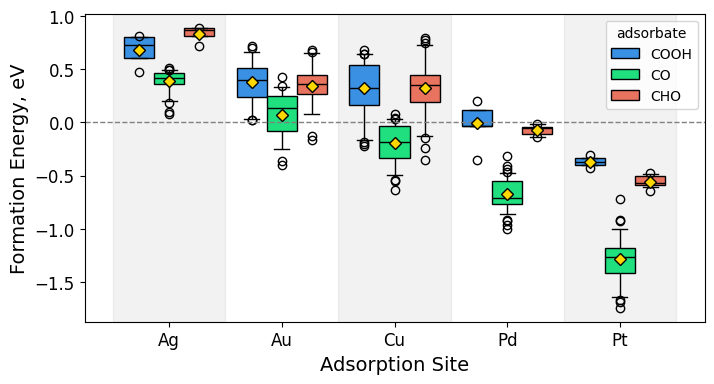

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(x='MSiteCSymb_1', y='BE', data=results_df, hue='adsorbate', palette={'COOH': 'dodgerblue', 'CHO': 'tomato', 'CO': 'springgreen'},
                hue_order=['COOH', 'CO', 'CHO'], showmeans=True, whis=[5, 95],
                meanprops={"marker": "D", "markeredgecolor": "black", "markerfacecolor": "gold"},
                order=['Ag', 'Au', 'Cu', 'Pd', 'Pt'], linewidth=1., linecolor='black', ax=ax)
ax.set_ylabel('Formation Energy, eV', fontsize=14)
ax.set_xlabel('Adsorption Site', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add alternating shading using axvspan
# Note: the x positions for categorical data are integers (0, 1, 2, ...)
metal_sites = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
for i, site in enumerate(metal_sites):
    # Shade every other category (adjust alpha and color as desired)
    if i % 2 == 0:
        ax.axvspan(i - 0.5, i + 0.5, color='grey', alpha=0.1)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.show()

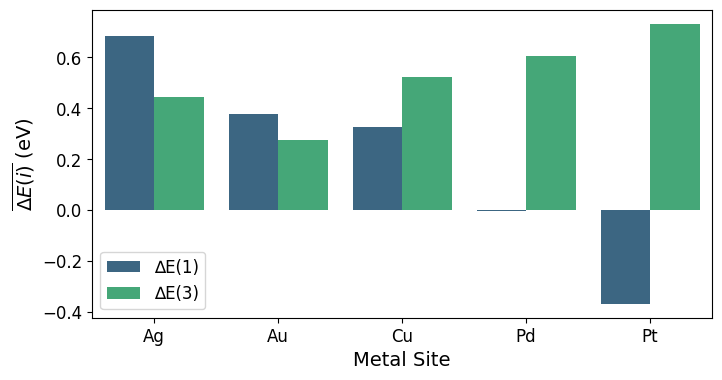

In [35]:
plotdata_grouped = (
    results_df
    .groupby(['adsorbate', 'MSiteCSymb_1'])
    .agg({'BE': ['min', 'max', 'mean', 'std', 'count']}) 
).reset_index()

plotdata_grouped.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in plotdata_grouped.columns]
delta_e_1 = plotdata_grouped.query('adsorbate == "COOH"')[['MSiteCSymb_1', 'BE_mean']].copy()
delta_e_1.columns = ['MSiteCSymb_1', '∆E(1)']
delta_e_2 = plotdata_grouped.query('adsorbate == "CO"')[['MSiteCSymb_1', 'BE_mean']].copy()
delta_e_2.columns = ['MSiteCSymb_1', 'BE_CO']
delta_e_3 = plotdata_grouped.query('adsorbate == "CHO"')[['MSiteCSymb_1', 'BE_mean']].copy()
delta_e_3.columns = ['MSiteCSymb_1', 'BE_CHO']
delta_e_2['∆E(2)'] = delta_e_2['BE_CO'] - plotdata_grouped.query('adsorbate == "COOH"')['BE_mean'].values
delta_e_3['∆E(3)'] = delta_e_3['BE_CHO'] - delta_e_2['BE_CO'].values


# Merge the two DataFrames on the metal site column
data_merged = delta_e_1[['MSiteCSymb_1', '∆E(1)']].merge(
    delta_e_3[['MSiteCSymb_1', '∆E(3)']], on='MSiteCSymb_1'
)

# Reshape the merged DataFrame from wide to long format
data_long = data_merged.melt(id_vars='MSiteCSymb_1', 
                             value_vars=['∆E(1)', '∆E(3)'],
                             var_name='Series', 
                             value_name='delta_E')

# Create the grouped bar plot using hue for the series
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='MSiteCSymb_1', y='delta_E', hue='Series', data=data_long, palette='viridis', ax=ax)
ax.set_xlabel('Metal Site', fontsize=14)
ax.set_ylabel(r'$\overline{\Delta E(i)}$ (eV)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title=None, fontsize=12)
plt.show()

def filter_extreme_outliers(df, thr=-3):
    return df[df.BE > thr]

filtered_df = filter_extreme_outliers(results_df, thr=-3)

In [36]:
def calculate_binding_energy(x, ref_energies):
    if x['adsorbate'] == 'COOH':
        return x['energy'] - ref_energies[x['NP']] - ref_energies['H2'] / 2 - ref_energies['CO2']
    elif x['adsorbate'] == 'CHO':
        return x['energy'] + ref_energies['H2O'] - ref_energies[x['NP']] - ref_energies['CO2'] - ref_energies['H2'] * 3/2
    elif x['adsorbate'] == 'CO':
        return x['energy'] + ref_energies['H2O'] - ref_energies[x['NP']] - ref_energies['CO2'] - ref_energies['H2']
    else:
        return 'NA'

def filter_grouping(df, nanop='MS'):
    dddd = df.query(f'NP == "{nanop}"').copy()
    # Group by 'MSiteCSymb_1' (Index of metal bound to C), check that has all 3 adsorbates
    grouped_df = dddd.groupby('MSiteCIdx_1').filter(lambda x: x['adsorbate'].nunique() == 3)
    
    result_stats = grouped_df.groupby(['MSiteCIdx_1', 'MSiteCSymb_1', 'adsorbate'])['BE'].agg(['min', 'mean', 'max', 'std'])
    new_df = result_stats.reset_index().pivot_table(
        index=['MSiteCIdx_1', 'MSiteCSymb_1'],  # Setting 'MSiteCIdx_1' as the index
        columns='adsorbate',    # Creating new columns from the 'adsorbate' values
        values=('min'),         # Choosing the 'min' column for pivot values
        aggfunc='min'           # Aggregating function
    )
    print(new_df)
    new_df.columns = [f'BE_{col}_min' for col in new_df.columns]
    new_df['Delta_1'] = new_df['BE_COOH_min']
    new_df['Delta_3'] = new_df['BE_CHO_min'] - new_df['BE_CO_min']
    new_df['Eads_CO'] = new_df['BE_CO_min'] - ref_energies['CO'] + ref_energies['CO2'] + ref_energies['H2'] - ref_energies['H2O']
    new_df.sort_values('Delta_3', ascending=True)
    # Added on 2025-02-20
    new_df.reset_index(inplace=True)
    return new_df

ref_energies = {
    'H2': -6.988848,
    'CO2': -22.266944,
    'H2O': -14.148287,
    'CO': -14.423918,
    }

In [37]:
plot_data_A = filter_grouping(results_df, nanop='A')
plot_data_A['np'] = 'A'

plot_data_B = filter_grouping(results_df, nanop='B')
plot_data_B['np'] = 'B'

plot_data_C = filter_grouping(results_df, nanop='C')
plot_data_C['np'] = 'C'

plot_data_D = filter_grouping(results_df, nanop='D')
plot_data_D['np'] = 'D'

plot_data_E = filter_grouping(results_df, nanop='E')
plot_data_E['np'] = 'E'

plot_data_F = filter_grouping(results_df, nanop='F')
plot_data_F['np'] = 'F'

plot_data_H = filter_grouping(results_df, nanop='H')
plot_data_H['np'] = 'H'

consolidated = pd.concat([plot_data_A, plot_data_B, plot_data_C, plot_data_D, plot_data_E, plot_data_F, plot_data_H], ignore_index=True)
consolidated.set_index(['np', 'MSiteCIdx_1', 'MSiteCSymb_1'], inplace=True)

adsorbate                      CHO        CO      COOH
MSiteCIdx_1 MSiteCSymb_1                              
3           Cu            0.448628 -0.349089  0.318029
4           Cu            0.312387 -0.311395  0.115338
5           Cu            0.141521 -0.276691  0.158349
8           Cu            0.317070  0.036666  0.195935
9           Cu            0.435479 -0.069211  0.238768
14          Pt           -0.558679 -1.085784 -0.427614
24          Au            0.224541  0.305592  0.135782
25          Au            0.261990  0.322388  0.162247
28          Au           -0.160841  0.319223  0.023262
29          Au            0.127646  0.145520  0.027623
31          Au            0.450299 -0.400663  0.515180
32          Au            0.411058  0.184789  0.501033
36          Pd           -0.132628 -0.826759 -0.037841
37          Pd           -0.048315 -0.767998  0.112461
46          Ag            0.714874  0.182239  0.478142
adsorbate                      CHO        CO      COOH
MSiteCIdx_

Slope: 0.997494494632864, Intercept: 0.43976425346007103


,clean,CO,CHO,BE_CO,BE_CHO,Eads_CO
Ag,-132.472351,-146.904777,-149.894900,0.675079,1.179380,-0.008508
Au,-160.871002,-175.401598,-178.675270,0.576909,0.797661,-0.106678
Cu,-194.904426,-209.805246,-212.635045,0.206685,0.871309,-0.476902
Pd,-281.445022,-296.942415,-300.051943,-0.389887,-0.004992,-1.073474
Pt,-332.765305,-348.557175,-351.628314,-0.684365,-0.261080,-1.367952


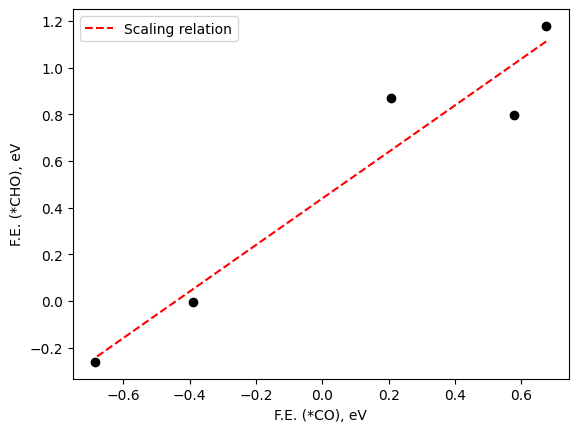

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression

puremetal_df = pd.read_pickle('puremetals_111_CHO_CO.pkl') 

X = puremetal_df['BE_CO'].values.reshape(-1, 1)
y = puremetal_df['BE_CHO'].values.reshape(-1, 1)
model_scaling = LinearRegression()
model_scaling.fit(X, y)
slope = model_scaling.coef_[0][0]
intercept = model_scaling.intercept_[0]
print(f'Slope: {slope}, Intercept: {intercept}')
plt.plot(X, model_scaling.predict(X), 'r--', label='Scaling relation')
plt.plot(puremetal_df['BE_CO'], puremetal_df['BE_CHO'], 'ok')
plt.xlabel('F.E. (*CO), eV')
plt.ylabel('F.E. (*CHO), eV')
plt.legend()

puremetal_df

/var/folders/r_/lc4wctg15fn2kjd_85v0kjw80000gp/T/ipykernel_5360/2495610320.py:33: UserWarning: The following kwargs were not used by contour: 'negative_linestyle'
  CS_lines = ax.contour(X, Y, delta_e_2, levels=nonzero_levels, colors='gray', linewidths=0.5, linestyles='solid', negative_linestyle='dashed')


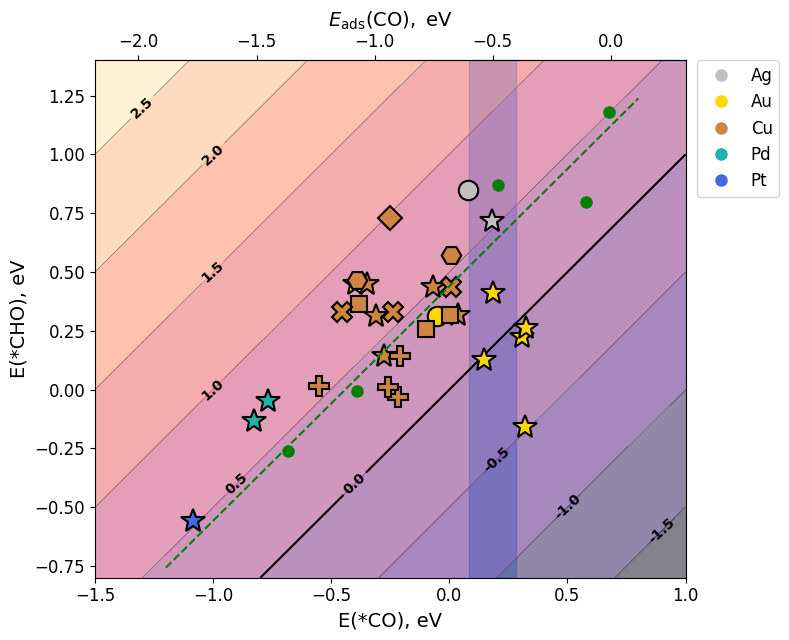

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def deltaE2(eads_co, be_cho):
    return be_cho - ( eads_co + ref_energies['CO'] - ref_energies['CO2'] - ref_energies['H2'] + ref_energies['H2O'] )

def beCO_2_adseCO(be_co):
    return be_co - ref_energies['CO'] + ref_energies['CO2'] + ref_energies['H2'] - ref_energies['H2O']

def adseCO_2_beCO(adseCO):
    return adseCO + ref_energies['CO'] - ref_energies['CO2'] - ref_energies['H2'] + ref_energies['H2O']

#eads_co = np.arange(-2, 0.01, 0.1)
be_co = np.arange(-1.5, 1.01, 0.1)
be_cho = np.arange(-0.8, 1.41, 0.1)

X, Y = np.meshgrid(be_co, be_cho)
delta_e_2 = Y - X #deltaE2(X, Y)

fig, ax = plt.subplots(figsize=(8, 6.5))

# Fill area between the vertical lines
co_ads_e_window_min = adseCO_2_beCO(-0.6)
co_ads_e_window_max = adseCO_2_beCO(-0.4)
ax.fill_betweenx(y=[-0.8, 1.4], x1=co_ads_e_window_min, x2=co_ads_e_window_max, color='dodgerblue', alpha=0.4)

# CONTOUR LINES
all_levels = np.arange(-2, 3.1, 0.5)
CS = ax.contourf(X, Y, delta_e_2, levels=all_levels,
                cmap='magma', alpha=0.5)

nonzero_levels = [lvl for lvl in all_levels if lvl != 0]
CS_lines = ax.contour(X, Y, delta_e_2, levels=nonzero_levels, colors='gray', linewidths=0.5, linestyles='solid', negative_linestyle='dashed')
CS_zero = ax.contour(X, Y, delta_e_2, levels=[0], colors='black', linewidths=1.5)
# Set Manualy the location of the cs_line labels
manual_positions = [
    (-1.3,  1.2),
    (-1.,  1),
    (-1, 0.5),
    (-1, 0.0),
    (-0.9, -0.4),
    #(-0.4, -0.4),
    (0.2, -0.3),
    (0.5, -0.5),
    (0.9, -0.6)
]
texts = ax.clabel(CS_lines, inline=True, fontsize=10, colors='k', fmt='%1.1f', manual=manual_positions)
zero_texts = ax.clabel(CS_zero, inline=True, fontsize=10, colors='k', fmt='%1.1f', manual=[(-0.4,-0.4)])
for txt in texts:
    txt.set_fontweight('bold')
for zero_txt in zero_texts:
    zero_txt.set_fontweight('bold')

colorcode = {'Ag': 'silver', 'Au': 'gold', 'Cu': 'peru', 'Pd': 'lightseagreen', 'Pt': 'royalblue'}
markers = {'A': '*', 'C': 'o', 'H': 's', 'D': 'D', 'F': 'X', 'E': 'P', 'B': 'H'}
marker_sizes = {'A': 18, 'C': 14, 'H': 12, 'D': 12, 'F': 14, 'E': 14, 'B': 14}
dataframes = {
        'A': plot_data_A,
        'C': plot_data_C, 
        'H': plot_data_H, 
        'D': plot_data_D, 
        'F': plot_data_F, 
        'E': plot_data_E, 
        'B': plot_data_B}

for np_label in dataframes.keys():
    for i, row in dataframes[np_label].iterrows():
        markercolor = colorcode[row['MSiteCSymb_1']]
        ax.plot(row['BE_CO_min'], row['BE_CHO_min'], markers[np_label], 
                markersize=marker_sizes[np_label], color=markercolor, markeredgecolor='black', markeredgewidth=1.5, 
                alpha=1)

# Plot the DFT-calculated for the scaling relation (Pure Metals)
plt.plot(puremetal_df['BE_CO'], puremetal_df['BE_CHO'], 'og', markersize=8, alpha=1.)
x_scaling = np.linspace(-1.2, 0.8, 4)
y_scaling = model_scaling.predict(x_scaling.reshape(-1, 1))
plt.plot(x_scaling, y_scaling, 'g--', label='Scaling relation', linewidth=1.5)

# Box with the color code outside the plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colorcode.values()]
labels = list(colorcode.keys())

plt.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=12)

plt.xlabel('E(*CO), eV', fontsize=14)
plt.ylabel('E(*CHO), eV', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# drop the whole ax.twiny() block
forward = beCO_2_adseCO   # bottom→top
inverse = adseCO_2_beCO   # top→bottom

secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel(r'$E_{\rm ads}(\mathrm{CO}),\ \mathrm{eV}$', fontsize=14)
secax.tick_params(axis='x', labelsize=12)

plt.tight_layout()